# Contact Analysis

## Chuan Ping

### This Jupyter Notebook file contains all codes related to contact analysis of the ATF4 protein
Other analyses will be included in separate files

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import mdtraj as md
import MDAnalysis as mda

from contact_map import ContactFrequency, ContactDifference

import nglview as nv
import ipywidgets

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('bmh')

## Important data and functions necessary for the project
This section defines constants, functions, models that are beneficial for the analysis.

In [60]:
# This block specifies important parameters.
ns_per_frame  = 0.02

eq_frame_1    = 40000 # The starting frame, the trajectory after which is considered "equilibriated"
# eq_frame_2    = 
# eq_frame_3    = 

cutoffValue   = 0.25 # The threshold frequency of contacts
howManyFrames = 20 # Out of how many frames should one frame be selected (computational power limited)

In [38]:
# This is a list method not directly related to the analysis. 
# Very useful in removing redundant amino acids

def removeDuplicates(list):
    """
    Remove duplicates in a list. This is used to prevent add_representation from malfunctioning
    due to one residue may have more than one interactions with others
    
    list: the original list that may or may not contain duplicates
    
    output: a list without replicates
    """
    output = []
    [output.append(x) for x in list if x not in output]
    return output

## Loading and Showing the Trajectory Files
Just loading one trajectory file (as concatenated) should be enough. When the data collection is complete, simply put all data in.

In [7]:
%%time
traj1 = md.load_hdf5('/Users/cping/Desktop/ATF4/replica1/traj_rep_1.h5') 
#traj1.center_coordinates(traj1)
print(traj1)

<mdtraj.Trajectory with 113690 frames, 5380 atoms, 352 residues, and unitcells>
CPU times: user 35.8 s, sys: 23.9 s, total: 59.6 s
Wall time: 46min 24s


In [8]:
%%time
topology1 = traj1.topology
print(topology1)

<mdtraj.Topology with 1 chains, 352 residues, 5380 atoms, 5430 bonds>
CPU times: user 163 µs, sys: 124 µs, total: 287 µs
Wall time: 270 µs


In [ ]:
# %%time
# traj1.superpose(traj1, traj1)
# show1 = nv.show_mdtraj(traj1)
# show1

## Using Rg values to select equilibriated portions
This is for contact analysis. It is selected by estimating.
#### Note that there may exist a "systematic" or "scientific" way to determine what portions can be counted as "equilibriated" 

In [ ]:
%%time
# Select the Alpha Carbon atom of every residue of the trajectory
ca_1      = traj1.top.select('name CA')
ca_traj_1 = traj1.atom_slice(ca_1)

# Calculate the RMSD and Rg of three replicas
rmsd_1   = md.rmsd(ca_traj_1, ca_traj_1[0])
rg_1     = md.compute_rg(ca_traj_1)

In [ ]:
# Plots the radius of gyration of the trajectory

time_1 = ns_per_frame*np.arange(len(rg_1))

plt.plot(time_1, rg_1)
plt.legend(['rg'])
plt.xlabel('Time/ns')
plt.ylabel('Radius of Gyration')

In [26]:
%%time
# Gets the equilibriated portion of the trajectory
traj1_eq = traj1[eq_frame_1::]
print(traj1_eq)

<mdtraj.Trajectory with 73690 frames, 5380 atoms, 352 residues, and unitcells>
CPU times: user 1.84 s, sys: 2.76 s, total: 4.6 s
Wall time: 26.4 s


In [27]:
print("The total length of the trajectory is " + str(int(ns_per_frame * traj1.n_frames)) + " ns.")
print("The length of the equilibriated portion is " + str(int(ns_per_frame * traj1_eq.n_frames)) + " ns.")

The total length of the trajectory is 2273 ns.
The length of the equilibriated portion is 1473 ns.


## Contact Map
This gives a rough idea of the contacts. Detailed residue-to-residue contact analyses will be put forward later.

In [29]:
%%time
# It is regretfully sad that we cannot take every frame into calculating contact frequency. 1 in 20 frames chosen.
traj1_contacts = ContactFrequency(traj1_eq[::howManyFrames])

CPU times: user 2min 53s, sys: 1.26 s, total: 2min 54s
Wall time: 2min 55s


CPU times: user 5.04 s, sys: 105 ms, total: 5.14 s
Wall time: 5.33 s


Text(0, 0.5, 'Residue')

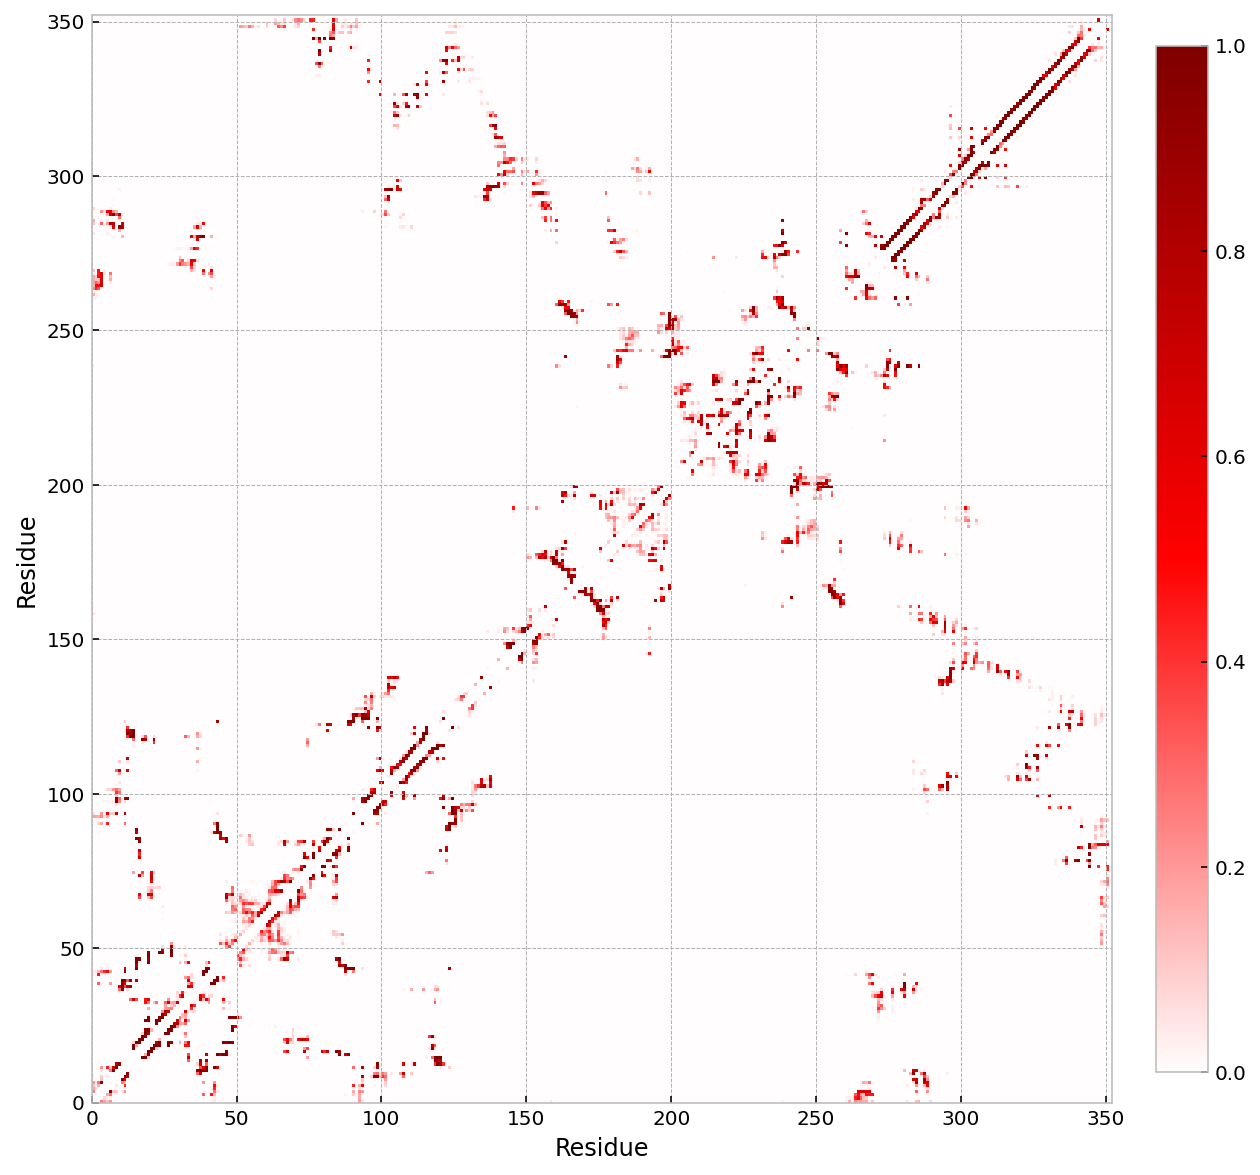

In [30]:
%%time
fig, ax = traj1_contacts.residue_contacts.plot(figsize=(10,10))
plt.xlabel("Residue")
plt.ylabel("Residue")

## Detailed Contact Analyses between four "regions" of the ATF4 protein

In [31]:
# This specifies the residue numbers of the four visual regions of the ATF4 protein.
# Rationale drawn from Steven's paper. Note that all residues were counted, although his paper does not indicate so.

tad_1  = range(0,155)
tad_2  = range(156,275)
bzip_1 = range(276,300)
bzip_2 = range(301,351)

In [34]:
# This function returns a list that can be quoted in visualization

def getContactIndex(contacts, topology, region1, region2, cutoffValue):
    """
    contacts: the contact map of the trajectory
    topology: the topology of the trajectory
    region1/2: the regions of residues of interest, as a range
    cutoffValue: the threshold of level of contacts
    
    returns a list containing the residue numbers of the residues that are in contact(this is for visualization)
    """
    resid_1_list = [] # Creates an empty list storing values of the residues
    resid_2_list = []
    for resid1 in region1:
        for contact in contacts.residue_contacts.most_common(topology.residue(resid1)):
            if contact[1] > cutoffValue and contact[0][1].index in region2:
                resid_1_list.append(contact[0][0].index + 1) # +1 to compensate for list starting with 0
                resid_2_list.append(contact[0][1].index + 1)
    return removeDuplicates(resid_1_list), removeDuplicates(resid_2_list)

In [36]:
%%time
# Constructs the contact map between regions of interest

def contactBetweenRegions(contacts, topology, region1, region2, cutoffValue, outputFileName):
    """
    contacts: the contact map of the trajectory
    topology: the topology of the trajectory
    region1/2: the regions of residues of interest, as a range
    cutoffValue: the threshold of level of contacts
    
    returns 
    1) a txt file outlining important contacts between two regions of interest in the protein
    2) a list containing the residue numbers of the residues that are in contact(this is for visualization)
    """
    resid_1_list = [] # Creates two emply lists storing indices of the residues
    resid_2_list = []
    
    with open(outputFileName, 'w') as output:
        output.write(outputFileName + '\n\n')
        for resid1 in region1:
            for contact in contacts.residue_contacts.most_common(topology.residue(resid1)):
                if contact[1] > cutoffValue and contact[0][1].index in region2:
                    resid_1_list.append(contact[0][0].index)
                    resid_2_list.append(contact[0][1].index)
                    output.write(str(contact) + '\n\n')
                    
# Obtains the contact information of the four interacting regions (excluding self)

contactBetweenRegions(traj1_contacts, topology1, tad_1, bzip_1, cutoffValue, "tad_1_bzip_1.txt")
contactBetweenRegions(traj1_contacts, topology1, tad_2, bzip_2, cutoffValue, "tad_2_bzip_2.txt")
contactBetweenRegions(traj1_contacts, topology1, tad_1, tad_2, cutoffValue, "tad_1_tad_2.txt")
contactBetweenRegions(traj1_contacts, topology1, bzip_1, bzip_2, cutoffValue, "bzip_1_bzip_2.txt")

CPU times: user 1.17 s, sys: 6.77 ms, total: 1.18 s
Wall time: 1.18 s


## Visualization of the contacts

**Some parameter names are reused.**

In [39]:
# This function is constructed to accommodate the selection feature of nglview.

def obtainSelection(list):
    """
    To accommodate the selection feature of nglview. 
    
    list: input list of residue indices, numbers only
    
    output: a string in the format of what add_representation will take
    """
    output = ""
    for x in list:
        output += ("(" + str(x) + "),")
    output = output[:-1] # Removes the final comma
    return output

In [62]:
# If there are too many contacts, display may become choppy. 
# I am using different representations across plots to see which one looks better.

resid_1_list = getContactIndex(traj1_contacts, topology1, tad_1, bzip_1, cutoffValue)[0]
print(resid_1_list)
resid_2_list = getContactIndex(traj1_contacts, topology1, tad_1, bzip_1, cutoffValue)[1]
print(resid_2_list)

show_tad_1_bzip_1= nv.show_mdtraj(traj1_eq[::howManyFrames])
show_tad_1_bzip_1.add_representation('licorice', selection = obtainSelection(resid_1_list), color='red')
show_tad_1_bzip_1.add_representation('licorice', selection = obtainSelection(resid_2_list), color='blue')
show_tad_1_bzip_1

[4, 7, 9, 10, 11, 36, 37, 102, 103, 106, 107, 137, 138, 153, 154, 155]
[285, 288, 284, 287, 277, 280, 296, 299, 294, 297, 293, 295, 298]


NGLWidget(max_frame=3684)

In [63]:
resid_1_list = getContactIndex(traj1_contacts, topology1, tad_1, bzip_2, cutoffValue)[0]
print(resid_1_list)
resid_2_list = getContactIndex(traj1_contacts, topology1, tad_1, bzip_2, cutoffValue)[1]
print(resid_2_list)

show_tad_1_bzip_2= nv.show_mdtraj(traj1_eq[::howManyFrames])
show_tad_1_bzip_2.add_representation('licorice', selection = obtainSelection(resid_1_list), color='red')
show_tad_1_bzip_2.add_representation('licorice', selection = obtainSelection(resid_2_list), color='blue')
show_tad_1_bzip_2

[65, 67, 76, 77, 79, 81, 83, 84, 90, 100, 105, 106, 108, 109, 113, 116, 122, 123, 125, 129, 138, 139, 140, 141, 145, 146, 154]
[349, 351, 344, 336, 345, 341, 342, 350, 327, 324, 320, 323, 321, 326, 330, 334, 331, 335, 317, 304, 310, 306, 305, 302]


NGLWidget(max_frame=3684)

In [67]:
resid_1_list = getContactIndex(traj1_contacts, topology1, tad_2, bzip_1, cutoffValue)[0]
print(resid_1_list)
resid_2_list = getContactIndex(traj1_contacts, topology1, tad_2, bzip_1, cutoffValue)[1]
print(resid_2_list)

show_tad_2_bzip_1= nv.show_mdtraj(traj1_eq[::howManyFrames])
show_tad_2_bzip_1.add_representation('licorice', selection = obtainSelection(resid_1_list), color='red')
show_tad_2_bzip_1.add_representation('licorice', selection = obtainSelection(resid_2_list), color='blue')
show_tad_2_bzip_1

[157, 159, 161, 178, 179, 180, 181, 182, 236, 237, 239, 259, 261, 268, 269, 273, 274, 275]
[286, 287, 295, 283, 279, 280, 278, 285, 277, 281]


NGLWidget(max_frame=3684)

In [68]:
resid_1_list = getContactIndex(traj1_contacts, topology1, tad_2, bzip_2, cutoffValue)[0]
print(resid_1_list)
resid_2_list = getContactIndex(traj1_contacts, topology1, tad_2, bzip_2, cutoffValue)[1]
print(resid_2_list)

show_tad_2_bzip_2= nv.show_mdtraj(traj1_eq[::howManyFrames])
show_tad_2_bzip_2.add_representation('contact', selection = obtainSelection(resid_1_list), color='red')
show_tad_2_bzip_2.add_representation('contact', selection = obtainSelection(resid_2_list), color='blue')
show_tad_2_bzip_2

[189, 193]
[303, 302]


NGLWidget(max_frame=3684)